In [8]:
import pandas as pd
import pmdarima as pm
from matplotlib import pyplot as plt
from pmdarima.arima import ndiffs, nsdiffs
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('H1.csv')
date_index = pd.to_datetime(
    df['ArrivalDateYear'].astype(str) + '-' + \
    df['ArrivalDateMonth'].astype(str) + '-' + \
    df['ArrivalDateDayOfMonth'].astype(str),
    format='%Y-%B-%d')
df.set_index(date_index, inplace=True)
weekly_data = df[['IsCanceled']].resample('W').sum()
weekly_data['IsCanceled'] = weekly_data['IsCanceled'].astype(float)

In [3]:
weekly_data

,IsCanceled
2015-07-05,49.0
2015-07-12,48.0
2015-07-19,90.0
2015-07-26,74.0
2015-08-02,97.0
...,...
2017-08-06,188.0
2017-08-13,130.0
2017-08-20,183.0
2017-08-27,142.0


In [18]:
n_adf = ndiffs(weekly_data['IsCanceled'], test='adf')
print(f'Number of diffs to take: {n_adf}')
# estimate number of seasonal differences using a Canova-Hansen test
D = nsdiffs(weekly_data['IsCanceled'], m=10, max_D=12, test='ch')
print(f'Estimated D is {D}')

Number of diffs to take: 1
Estimated D is 0


In [38]:
train_data, test_data = train_test_split(weekly_data, test_size=0.05, shuffle=False)

In [47]:
train_data

,IsCanceled
2015-07-05,49.0
2015-07-12,48.0
2015-07-19,90.0
2015-07-26,74.0
2015-08-02,97.0
...,...
2017-06-25,137.0
2017-07-02,150.0
2017-07-09,122.0
2017-07-16,146.0


In [52]:
model = pm.auto_arima(train_data['IsCanceled'],
                      max_p=5, max_q=5, max_P=5, max_Q=5, max_order=20,
                      m=52, d=1, D=0,
                      seasonal=True, stepwise=True,
                      information_criterion='bic',
                      trace=True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : BIC=inf, Time=7.52 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : BIC=1143.290, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : BIC=1117.160, Time=0.44 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : BIC=1105.214, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[52]             : BIC=1138.655, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : BIC=1101.126, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : BIC=1105.212, Time=0.54 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : BIC=inf, Time=0.91 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : BIC=1105.563, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : BIC=1105.631, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : BIC=1112.521, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : BIC=1110.081, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[52]             : BIC=1096.868, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[52]             : BIC=1100.938, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[52]     

In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  102
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -515.679
Date:                Mon, 17 Apr 2023   AIC                           1037.358
Time:                        22:39:33   BIC                           1045.204
Sample:                    07-05-2015   HQIC                          1040.534
                         - 06-11-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6892      1.173      0.588      0.557      -1.610       2.988
ma.L1         -0.7154      0.073     -9.805      0.000      -0.858      -0.572
sigma2      1581.9944    222.488      7.110      0.000    1145.927    2018.062
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 1.07
Prob(Q):                              0.77   Prob(JB):                         0.59
Heteroskedasticity (H):               0.51   Skew:                             0.23
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
prediction = pd.DataFrame(model.predict(n_periods=11), index=test_data.index)
prediction.columns = ['Predicted_Cancellations']
predictions = prediction['Predicted_Cancellations']

predictions

2017-06-18    137.380943
2017-06-25    138.070141
2017-07-02    138.759339
2017-07-09    139.448537
2017-07-16    140.137735
2017-07-23    140.826932
2017-07-30    141.516130
2017-08-06    142.205328
2017-08-13    142.894526
2017-08-20    143.583724
2017-08-27    144.272921
2017-09-03           NaN
Freq: W-SUN, Name: Predicted_Cancellations, dtype: float64

In [35]:
test_data

,IsCanceled
2017-06-18,156.0
2017-06-25,137.0
2017-07-02,150.0
2017-07-09,122.0
2017-07-16,146.0
2017-07-23,146.0
2017-07-30,156.0
2017-08-06,188.0
2017-08-13,130.0
2017-08-20,183.0


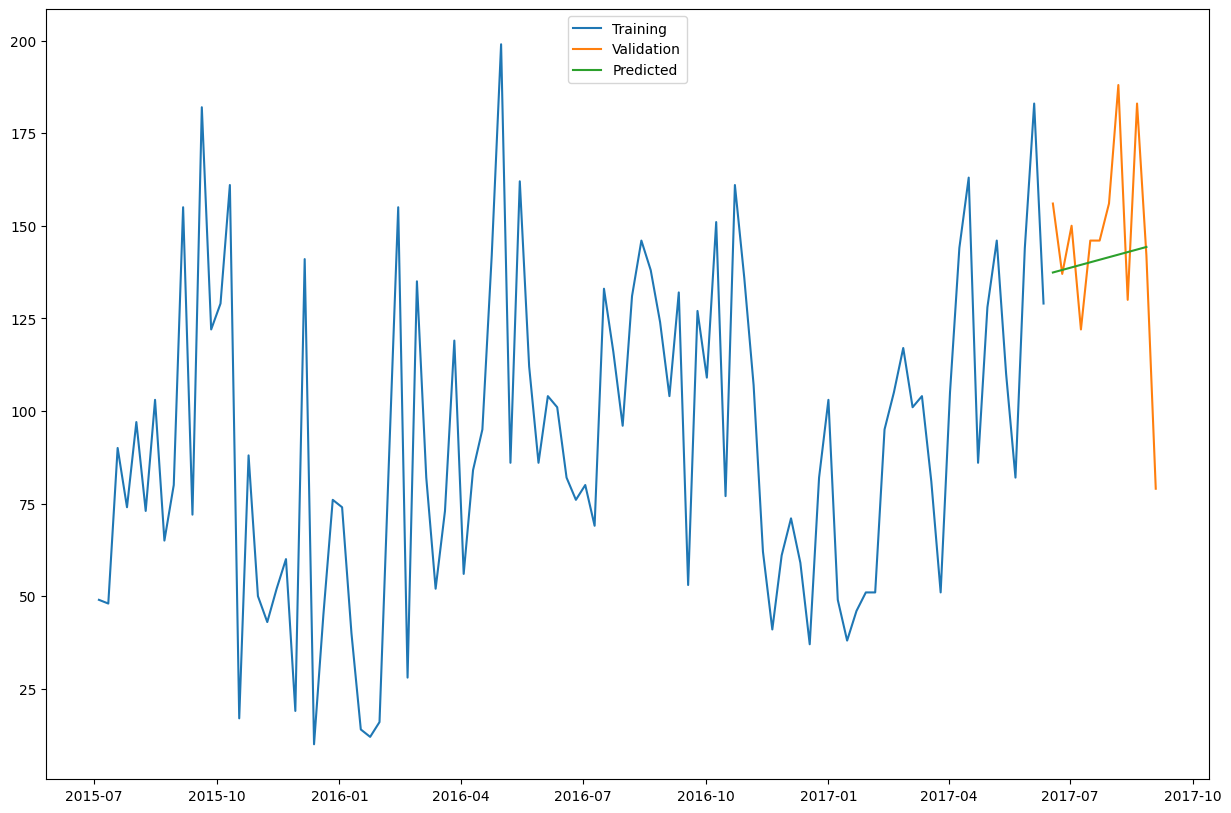

In [36]:
plt.figure(figsize=(15,10))
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Validation')
plt.plot(prediction, label='Predicted')
plt.legend(loc = 'upper center')
plt.show()